# Importign required modules

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Test transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 155895276.33it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 121622182.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67380736.33it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 25883870.61it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

SEED = 1
# To reproduce the same results across the sessions
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24


        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12


        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 8

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 6


        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             576
              ReLU-4            [-1, 8, 24, 24]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6           [-1, 16, 10, 10]           1,152
              ReLU-7           [-1, 16, 10, 10]               0
            Conv2d-8             [-1, 16, 8, 8]           2,304
              ReLU-9             [-1, 16, 8, 8]               0
           Conv2d-10             [-1, 10, 6, 6]           1,440
             ReLU-11             [-1, 10, 6, 6]               0
        AvgPool2d-12             [-1, 10, 1, 1]               0
Total params: 5,544
Trainable params: 5,544
Non-trainable params: 0
-----------------------------------

In [7]:
from tqdm import tqdm

# Aggregate loss and accuracy
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get batch data
    data, target = data.to(device), target.to(device)

    # Reset all gradients to zero
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Do calculate the grads in dackpropagation
    loss.backward()

    # Update the model weights
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Aggregate batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Update total test data loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Training & Testing

In [8]:
# Creat the mode and move it to CUDA
model = Net().to(device)

# Using stochastic gradient descent method for optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.43906259536743164 Batch_id=468 Accuracy=42.23: 100%|██████████| 469/469 [00:19<00:00, 23.99it/s]



Test set: Average loss: 0.3166, Accuracy: 8983/10000 (89.83%)

EPOCH: 1


Loss=0.11833450198173523 Batch_id=468 Accuracy=93.37: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]



Test set: Average loss: 0.1736, Accuracy: 9469/10000 (94.69%)

EPOCH: 2


Loss=0.12458106130361557 Batch_id=468 Accuracy=95.75: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]



Test set: Average loss: 0.1008, Accuracy: 9676/10000 (96.76%)

EPOCH: 3


Loss=0.22946752607822418 Batch_id=468 Accuracy=96.40: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]



Test set: Average loss: 0.0912, Accuracy: 9717/10000 (97.17%)

EPOCH: 4


Loss=0.10908620804548264 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]



Test set: Average loss: 0.0774, Accuracy: 9739/10000 (97.39%)

EPOCH: 5


Loss=0.02615435980260372 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]



Test set: Average loss: 0.0735, Accuracy: 9766/10000 (97.66%)

EPOCH: 6


Loss=0.030056923627853394 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]



Test set: Average loss: 0.0604, Accuracy: 9811/10000 (98.11%)

EPOCH: 7


Loss=0.010787688195705414 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]



Test set: Average loss: 0.0509, Accuracy: 9826/10000 (98.26%)

EPOCH: 8


Loss=0.16073723137378693 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]



Test set: Average loss: 0.0522, Accuracy: 9821/10000 (98.21%)

EPOCH: 9


Loss=0.022695576772093773 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]



Test set: Average loss: 0.0586, Accuracy: 9802/10000 (98.02%)

EPOCH: 10


Loss=0.03982528671622276 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]



Test set: Average loss: 0.0667, Accuracy: 9777/10000 (97.77%)

EPOCH: 11


Loss=0.03161795064806938 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]



Test set: Average loss: 0.0570, Accuracy: 9806/10000 (98.06%)

EPOCH: 12


Loss=0.052483659237623215 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]



Test set: Average loss: 0.0525, Accuracy: 9824/10000 (98.24%)

EPOCH: 13


Loss=0.01886191964149475 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]



Test set: Average loss: 0.0651, Accuracy: 9789/10000 (97.89%)

EPOCH: 14


Loss=0.1619194746017456 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]



Test set: Average loss: 0.0459, Accuracy: 9840/10000 (98.40%)



Text(0.5, 1.0, 'Test Accuracy')

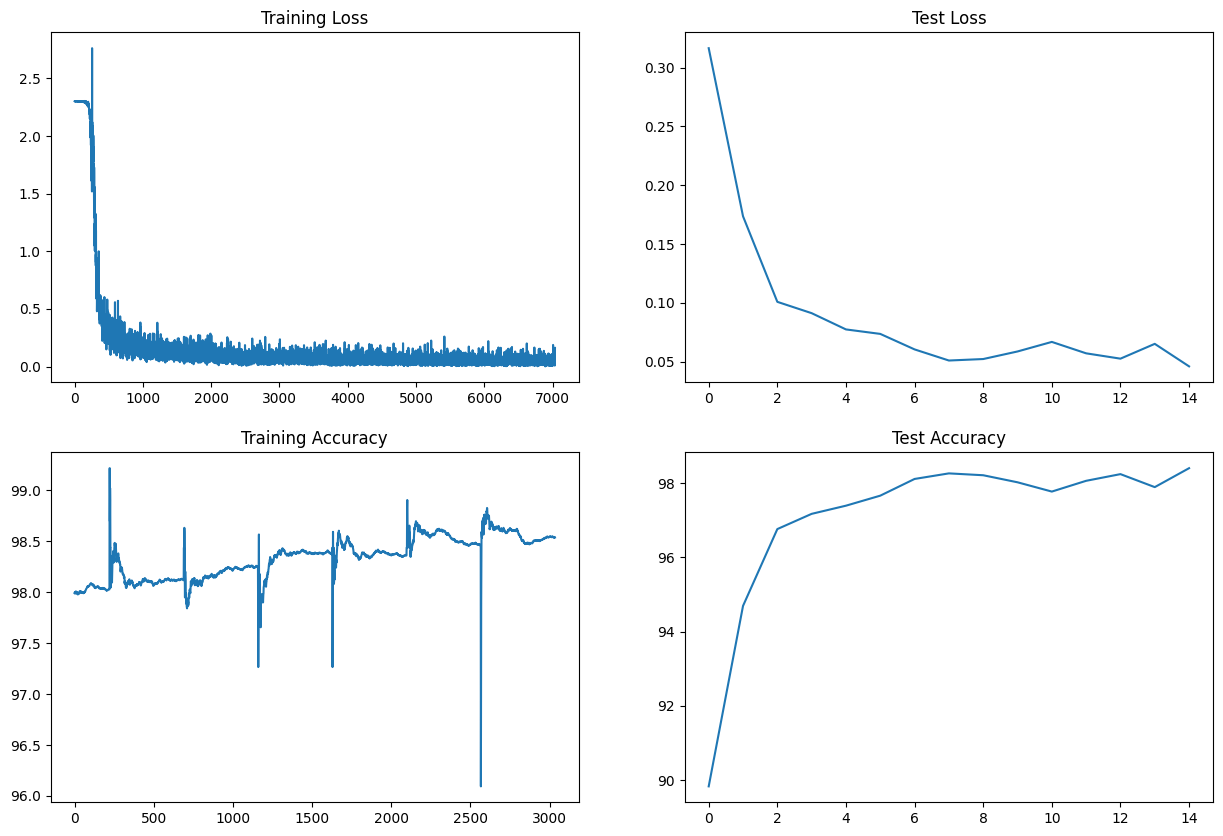

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Iteration 1
---
## Target:
*   Setting the basic Working Code, transforms, dataLoader, Training  & Test Loop.
*   Sellecting a  basic skeleton.
*   Selecting a lighter model interms of total parameters.

## Results:
*   Total params: 5,544
*   Best Training Accuracy: 98.54%
*   Best Test Accuracy: 98.40%

## Analysis:
*   The accuracy of the model is a bit low.
*   The observed training and test accuracies are pretty much close.

